In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Load the models

In [19]:
# #load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'
data = pd.read_csv(datapath + '5-15-25-newNewTheta.csv')
data = pd.read_csv(datapath + '5-19-25-massOrder.csv')
data = pd.read_csv(datapath + '5-22-25-3BRfill.csv')


# #remove junk columns
# data = data.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [20]:
import matplotlib as mpl

In [23]:
data.columns

Index(['Unnamed: 0.1', 'EMcrossMax', 'EMfracstdMax', 'EPstdMax',
       'MMRstrengthMax', 'conjunctionMagMax', 'relConjunctionMagMax',
       'EMcrossMin', 'EMfracstdMin', 'EPstdMin', 'MMRstrengthMin',
       'conjunctionMagMin', 'relConjunctionMagMin', 'MEGNO', 'MEGNOstd',
       'massOrder', 'threeBRfillfac', 'Tsec', '2BRfillMax', '2BRfillMin',
       'InitialStable', 'Unnamed: 0', 'runstring', 'instability_time',
       'shadow_instability_time', 'Stable'],
      dtype='object')

add column taking the max of the two diff conjunction angle methods to see if we can reduce feature dimension without decreasing performance, currently the two methods are not consistent so you can not.... this seems like something that would be good to resolve

In [58]:
data['magMax'] = np.max([data['conjunctionMagMax'], data['relConjunctionMagMax']])
data['magMin'] = np.max([data['conjunctionMagMin'], data['relConjunctionMagMin']])


Make feature list to test threeBR importance

In [75]:

featuresThree = ['EMcrossMax', 'EMfracstdMax', 'EPstdMax',
       'MMRstrengthMax', 'conjunctionMagMax', 'relConjunctionMagMax',
       'EMcrossMin', 'EMfracstdMin', 'EPstdMin', 'MMRstrengthMin',
       'conjunctionMagMin', 'relConjunctionMagMin', 'MEGNO', 'MEGNOstd',
       'massOrder',  'Tsec', '2BRfillMax', '2BRfillMin', 'threeBRfillfac']
features = ['EMcrossMax', 'EMfracstdMax', 'EPstdMax',
       'MMRstrengthMax', 'conjunctionMagMax', 'relConjunctionMagMax',
       'EMcrossMin', 'EMfracstdMin', 'EPstdMin', 'MMRstrengthMin',
       'conjunctionMagMin', 'relConjunctionMagMin', 'MEGNO', 'MEGNOstd',
       'massOrder',  'Tsec', '2BRfillMax', '2BRfillMin']

In [60]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [61]:

trainX, trainY, testX, testY = train_test(data, features)

In [62]:
print(features)

['EMcrossMax', 'EMfracstdMax', 'EPstdMax', 'MMRstrengthMax', 'conjunctionMagMax', 'relConjunctionMagMax', 'EMcrossMin', 'EMfracstdMin', 'EPstdMin', 'MMRstrengthMin', 'conjunctionMagMin', 'relConjunctionMagMin', 'MEGNO', 'MEGNOstd', 'massOrder', 'Tsec', '2BRfillMax', '2BRfillMin']


In [63]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [64]:
model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 200,
                         )

In [65]:
model.fit(trainX,trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Text(0.5, 1.0, 'ROC curve when tested on all systems (AUC = 0.959)')

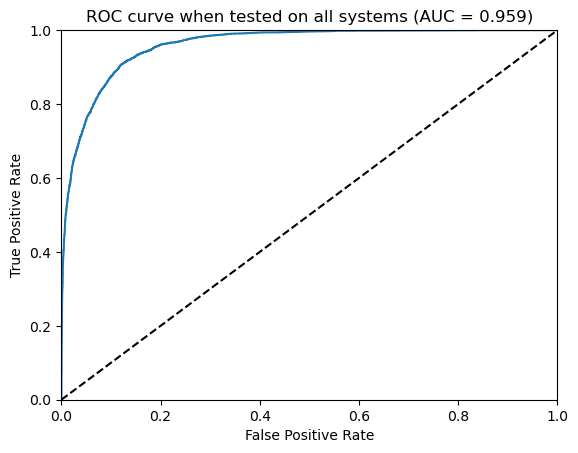

In [66]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve when tested on all systems (AUC = {0:.3f})'.format(roc_auc))

In [67]:
roc_auc

0.9592850928589531

Identify inconstant systems where the two conjunction angle calculations don't match
Our current understanding indicates sometimes the rel calculation wont detect a resonance, but the not rel calc should always find one IF the rel one finds a resonance, this is not the case however....

In [68]:
ind = ((data['conjunctionMagMax'] > 0.84) & (data['relConjunctionMagMax']<0.84))

In [70]:
# data[ind][['conjunctionMagMax','relConjunctionMagMax', 'conjunctionMagMin','relConjunctionMagMin']].to_csv('conjunctionAng.csv', index=True, index_label='FileNum')

In [71]:
data[ind][['conjunctionMagMax','relConjunctionMagMax', 'conjunctionMagMin','relConjunctionMagMin']]

,conjunctionMagMax,relConjunctionMagMax,conjunctionMagMin,relConjunctionMagMin
174,0.881383,0.776832,0.003829,0.003718
227,0.846080,0.775044,0.033751,0.068141
241,0.869670,0.516399,0.258895,0.275515
373,0.873879,0.758486,0.136846,0.043258
402,0.943451,0.258050,0.905243,0.971549
...,...,...,...,...
100706,0.971480,0.785350,0.306942,0.990666
101152,0.935784,0.051161,0.444536,0.715789
101828,0.882120,0.690818,0.663684,0.234756
102242,0.867717,0.598501,0.053892,0.036132


Feature Importance

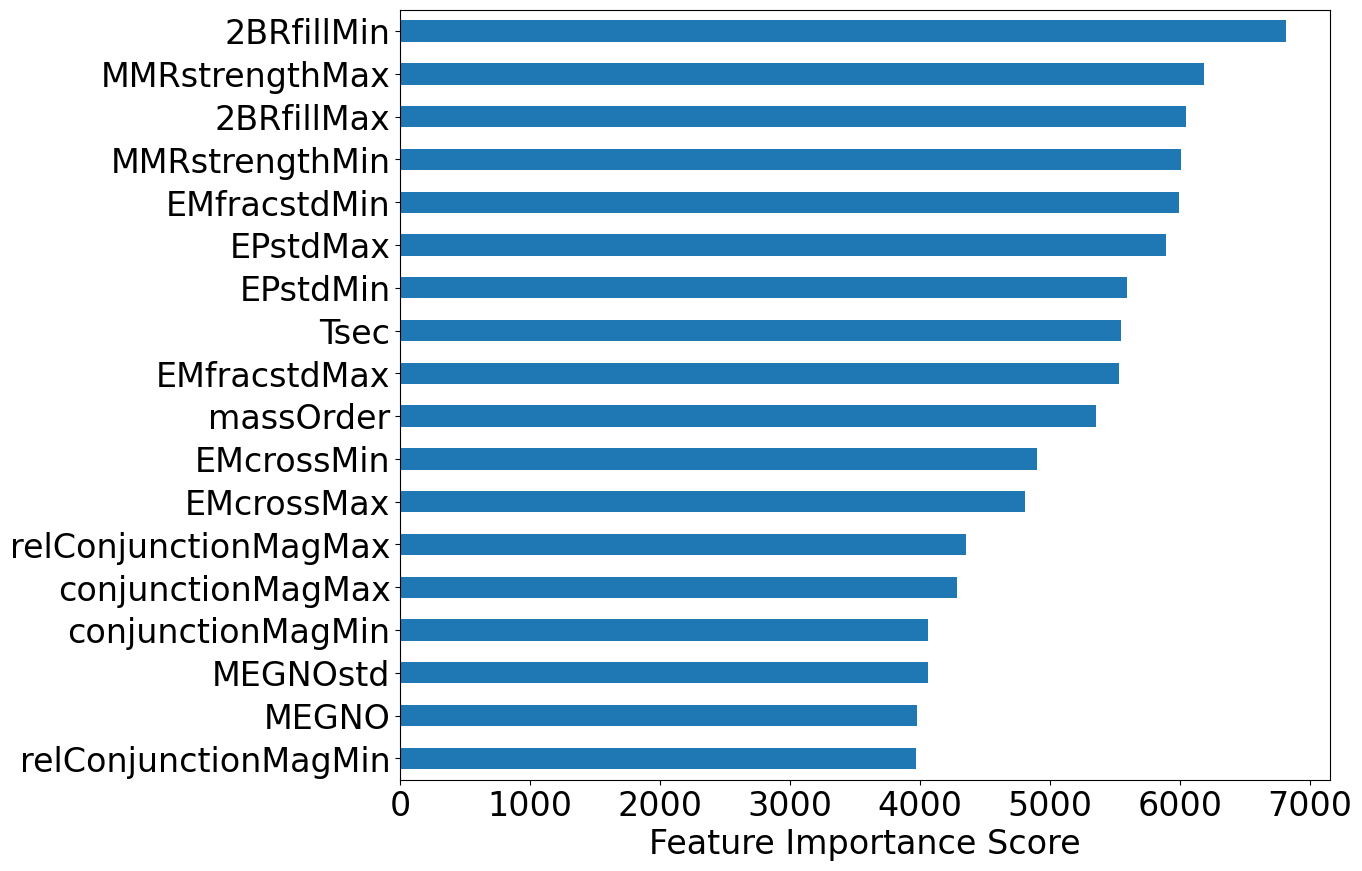

In [72]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,10), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

Testing function

In [73]:
def findAUC(features):
    trainX, trainY, testX, testY = train_test(data, features)

    model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 200,
                         )
    model.fit(trainX,trainY)
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)
    return roc_auc

Test 3BRfill

In [76]:
findAUC(featuresThree)

0.9598033523600787

In [77]:
findAUC(features)


0.9592850928589531

Seems to not make a large diff at all and might be redundant 

Demonstration of potential ablation study

In [80]:
len(featuresThree)

19

In [81]:
for i in range(len(featuresThree)):
    print(i,f'Not {featuresThree[i]}', findAUC(featuresThree[:i] + featuresThree[i+1:]))

0 Not EMcrossMax 0.9590449153353389
1 Not EMfracstdMax 0.9562100840693097
2 Not EPstdMax 0.9590151006444075
3 Not MMRstrengthMax 0.9594354638651964
4 Not conjunctionMagMax 0.9593583936502725
5 Not relConjunctionMagMax 0.9591933363897559
6 Not EMcrossMin 0.9587283489926063
7 Not EMfracstdMin 0.9584268096020498
8 Not EPstdMin 0.9591862252271488
9 Not MMRstrengthMin 0.9593945946146565
10 Not conjunctionMagMin 0.9599920555048205
11 Not relConjunctionMagMin 0.9597401202791177
12 Not MEGNO 0.9597879339677592
13 Not MEGNOstd 0.959941190032838
14 Not massOrder 0.9591072123092905
15 Not Tsec 0.9593133780337679
16 Not 2BRfillMax 0.9573107630106406
17 Not 2BRfillMin 0.9587243186089064
18 Not threeBRfillfac 0.9592850928589531


The reason why sometimes it does better when you remove features is since the complexity of the model is limited, so if the info is already redundant, forcing more features can be less effective (your not actually forcing the features)

This effect can be negated by allowing for more depth and more estimators